# Composition of energy consumption vs energy production
### EU-28, 2016

Using Eurostat data we construct an energy consumption composition and an energy production composition table for every EU-28 memberstate and then we visualise the country-level data with donut charts.

Data used is from the Eurostat [Energy database](https://ec.europa.eu/eurostat/web/energy/data/database):
* Simplified energy balances - annual data (__nrg_100a__) 
* Supply, transformation and consumption of renewable energies - annual data (__nrg_107a__)
* Primary production - all products - annual data (__nrg_109a__)

__jsonstat package__ was modified to work (again) with Eurostat API, modified version [can be found here](https://github.com/bencekd/jsonstat.py)

In [1]:
import pandas as pd
import jsonstat as jstat
from dfply import *
import matplotlib.pyplot as plt

# base url is the API endpoint of Eurostat
base_url = 'http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/'
bprod_url = 'nrg_109a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_en=B_100100&'
bcons_url = 'nrg_100a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&'
bcons_res_url = 'nrg_107a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&'

# specify country, time here
# EU-28 countries
country = ['HU','EE','PL','SK','SI','UK','ES','PT','IT','DE',\
           'FR','IE','AT','BG','RO','DK','SE','FI','MT','CY','LT','LV','EL','HR','CZ','NL','BE','LU']

# will work for 2017 once the year is updated in the annual series
year = '2016'
url = "".join(list(map(lambda t: "geo={}&".format(t), country)))[:-1]

# create the API urls
prod_url = base_url + bprod_url + url
cons_url = base_url + bcons_url + url
cons_res_url = base_url + bcons_res_url + url

In [2]:
# load primary production data and check it
prod_data = jstat.from_url(prod_url)
print(prod_data)
prod_df = prod_data.to_data_frame('time', content='id')
prod_df.reset_index(level=0, inplace=True)
prod_df.head()

name:   'Primary production - all products - annual data'
label:  'Primary production - all products - annual data'
size: 17064
+-----+----------+----------+------+------+
| pos | id       | label    | size | role |
+-----+----------+----------+------+------+
| 0   | unit     | unit     | 1    |      |
| 1   | product  | product  | 39   |      |
| 2   | indic_en | indic_en | 1    |      |
| 3   | geo      | geo      | 28   |      |
| 4   | time     | time     | 17   |      |
+-----+----------+----------+------+------+


,time,unit,product,indic_en,geo,Value
0,2000,KTOE,0000,B_100100,AT,9768.4
1,2001,KTOE,0000,B_100100,AT,9774.4
2,2002,KTOE,0000,B_100100,AT,9807.3
3,2003,KTOE,0000,B_100100,AT,9457.3
4,2004,KTOE,0000,B_100100,AT,9832.7


In [3]:
# load consumption data
cons_data = jstat.from_url(cons_url)
print(cons_data)
cons_df = cons_data.to_data_frame('time', content='id')
cons_df.reset_index(level=0, inplace=True)
cons_df.head()

name:   'Simplified energy balances - annual data'
label:  'Simplified energy balances - annual data'
size: 4261
+-----+-----------+-----------+------+------+
| pos | id        | label     | size | role |
+-----+-----------+-----------+------+------+
| 0   | unit      | unit      | 1    |      |
| 1   | product   | product   | 9    |      |
| 2   | indic_nrg | indic_nrg | 1    |      |
| 3   | geo       | geo       | 28   |      |
| 4   | time      | time      | 17   |      |
+-----+-----------+-----------+------+------+


,time,unit,product,indic_nrg,geo,Value
0,2000,KTOE,0000,B_100900,AT,29022.7
1,2001,KTOE,0000,B_100900,AT,30527.6
2,2002,KTOE,0000,B_100900,AT,30824.1
3,2003,KTOE,0000,B_100900,AT,32458.2
4,2004,KTOE,0000,B_100900,AT,33242.2


In [4]:
# load RES consumption data
cons_res_data = jstat.from_url(cons_res_url)
cons_res_df = cons_res_data.to_data_frame('time', content='id')
cons_res_df.reset_index(level=0,inplace=True)
# keep main categories -- see Energy-Data-Formulas.xlsx
cons_res_df = cons_res_df[~cons_res_df['product'].isin(['5500','5540','5546','5547','5548','5549'])]
cons_res_df.head()

,time,unit,product,indic_nrg,geo,Value
476,2000,KTOE,5510,B_100900,AT,3597.2
477,2001,KTOE,5510,B_100900,AT,3478.5
478,2002,KTOE,5510,B_100900,AT,3458.9
479,2003,KTOE,5510,B_100900,AT,2856
480,2004,KTOE,5510,B_100900,AT,3161


In [5]:
# get all the products in the production data
prod_df['product'].unique()

array(['0000', '2115', '2116', '2117', '2118', '2210', '2310', '2410',
       '3105', '3106', '3192', '3193', '4100', '5100', '5510', '5520',
       '5532', '5534', '5535', '5541', '55411', '55412', '55413', '55414',
       '55415', '55416', '5542', '55421', '55422', '55423', '55425',
       '55431', '55432', '5546', '5547', '5548', '5549', '5550', '7100'],
      dtype=object)

In [6]:
# flag consumption and prodution data as either RES or not RES
cons_df['RES'] = False
cons_df.loc[cons_df['product'] == '5500','RES'] = True

cons_res_df['RES'] = True

prod_df['RES'] = False
prod_df.loc[prod_df['product'].isin(['5510','5520','5530']),'RES'] = True

cons_df = cons_df[cons_df['RES']==False].append(cons_res_df)

cons_df.head()

,time,unit,product,indic_nrg,geo,Value,RES
0,2000,KTOE,0000,B_100900,AT,29022.7,False
1,2001,KTOE,0000,B_100900,AT,30527.6,False
2,2002,KTOE,0000,B_100900,AT,30824.1,False
3,2003,KTOE,0000,B_100900,AT,32458.2,False
4,2004,KTOE,0000,B_100900,AT,33242.2,False


In [7]:
# merge all data together
data_df = prod_df.drop('indic_en',axis='columns').assign(ind = 'prod').append(cons_df.drop('indic_nrg', axis='columns').assign(ind = 'cons'))
data_df.head()

,time,unit,product,geo,Value,RES,ind
0,2000,KTOE,0000,AT,9768.4,False,prod
1,2001,KTOE,0000,AT,9774.4,False,prod
2,2002,KTOE,0000,AT,9807.3,False,prod
3,2003,KTOE,0000,AT,9457.3,False,prod
4,2004,KTOE,0000,AT,9832.7,False,prod


In [8]:
# treat the data_df
# create categorical hierarchy

data_df = data_df[(data_df['product'].str.len() <= 4) | (data_df['product'] == '55431')].copy()

data_df['lv3'] = data_df['product'].str[:3]
data_df['lv2'] = data_df['product'].str[:2]
data_df['lv1'] = data_df['product'].str[:1]

data_df['category'] = data_df['lv1']
data_df.loc[data_df['lv1'] == '5','category'] = data_df[data_df['lv1'] == '5']['lv3']
data_df.loc[data_df['product']=='55431','category'] = '55431'
data_df.head()

,time,unit,product,geo,Value,RES,ind,lv3,lv2,lv1,category
0,2000,KTOE,0000,AT,9768.4,False,prod,000,00,0,0
1,2001,KTOE,0000,AT,9774.4,False,prod,000,00,0,0
2,2002,KTOE,0000,AT,9807.3,False,prod,000,00,0,0
3,2003,KTOE,0000,AT,9457.3,False,prod,000,00,0,0
4,2004,KTOE,0000,AT,9832.7,False,prod,000,00,0,0


In [9]:
# data preview
data_df[(data_df['geo'] == 'PL') & (data_df['time'] == '2016') & (data_df['category']=='2')]

,time,unit,product,geo,Value,RES,ind,lv3,lv2,lv1,category
849,2016,KTOE,2115,PL,0,False,prod,211,21,2,2
1325,2016,KTOE,2116,PL,9336.9,False,prod,211,21,2,2
1801,2016,KTOE,2117,PL,31076.2,False,prod,211,21,2,2
2277,2016,KTOE,2118,PL,0,False,prod,211,21,2,2
2753,2016,KTOE,2210,PL,11678.5,False,prod,221,22,2,2
3229,2016,KTOE,2310,PL,0,False,prod,231,23,2,2
3705,2016,KTOE,2410,PL,0,False,prod,241,24,2,2
849,2016,KTOE,2000,PL,49078.6,False,cons,200,20,2,2


In [10]:
# create data for donut charts

pie_data = data_df[(data_df['time'] == year) & (data_df['category']!='0')].copy()
pie_data['Value'] = pd.to_numeric(pie_data['Value'], errors="coerce")
pie_data = (pie_data >> group_by('geo','category','ind') >> summarize(total = X.Value.sum()))

pie_data.sort_values(by=['total'],ascending=False).head()

,ind,category,geo,total
122,cons,3,DE,108798.3
271,prod,510,FR,104005.6
270,cons,510,FR,104005.6
120,cons,2,DE,77226.6
266,cons,3,FR,75185.0


In [11]:
pie_data['category'].unique()

array(['2', '3', '4', '510', '520', '551', '552', '553', '554', '55431',
       '555', '6', '7'], dtype=object)

In [12]:
# translation
### Coal == Solid fuels
### Oil == Petroleum products

# loosely based on Energy-Data-Formulas.xlsx

trans = {
    "2": "Solid (e.g. coal)", 
    "3": "Oil",
    "4": "Gas",
    "510": "Nuclear",
    "554": "Biomass",
    "552": "Wind",
    "553": "Solar",
    "551": "Hydro",
    "55431": "Renewable waste",
    "555": "Geothermal",
    "520": "Derived heat",
    "6": "Electricity",
    "7": "Waste"
}

def trans_(x):
    try:
        return trans[x]
    except KeyError:
        return 'Other'

pie_data['cn'] = pie_data['category'].apply(lambda x: trans_(x))

In [29]:
ee = pie_data[(pie_data['geo'] == "EE") & (pie_data['ind']=='cons') & (pie_data['total'] > 0)].copy()
ee['p'] = ee['total'].apply(lambda x: x / ee['total'].sum())
ee

,ind,category,geo,total,cn,p
168,cons,2,EE,3796.8,Solid (e.g. coal),0.593835
170,cons,3,EE,1132.4,Oil,0.177112
172,cons,4,EE,428.3,Gas,0.066988
177,cons,551,EE,3.0,Hydro,0.000469
179,cons,552,EE,51.1,Wind,0.007992
183,cons,554,EE,911.6,Biomass,0.142578
190,cons,7,EE,70.5,Waste,0.011026


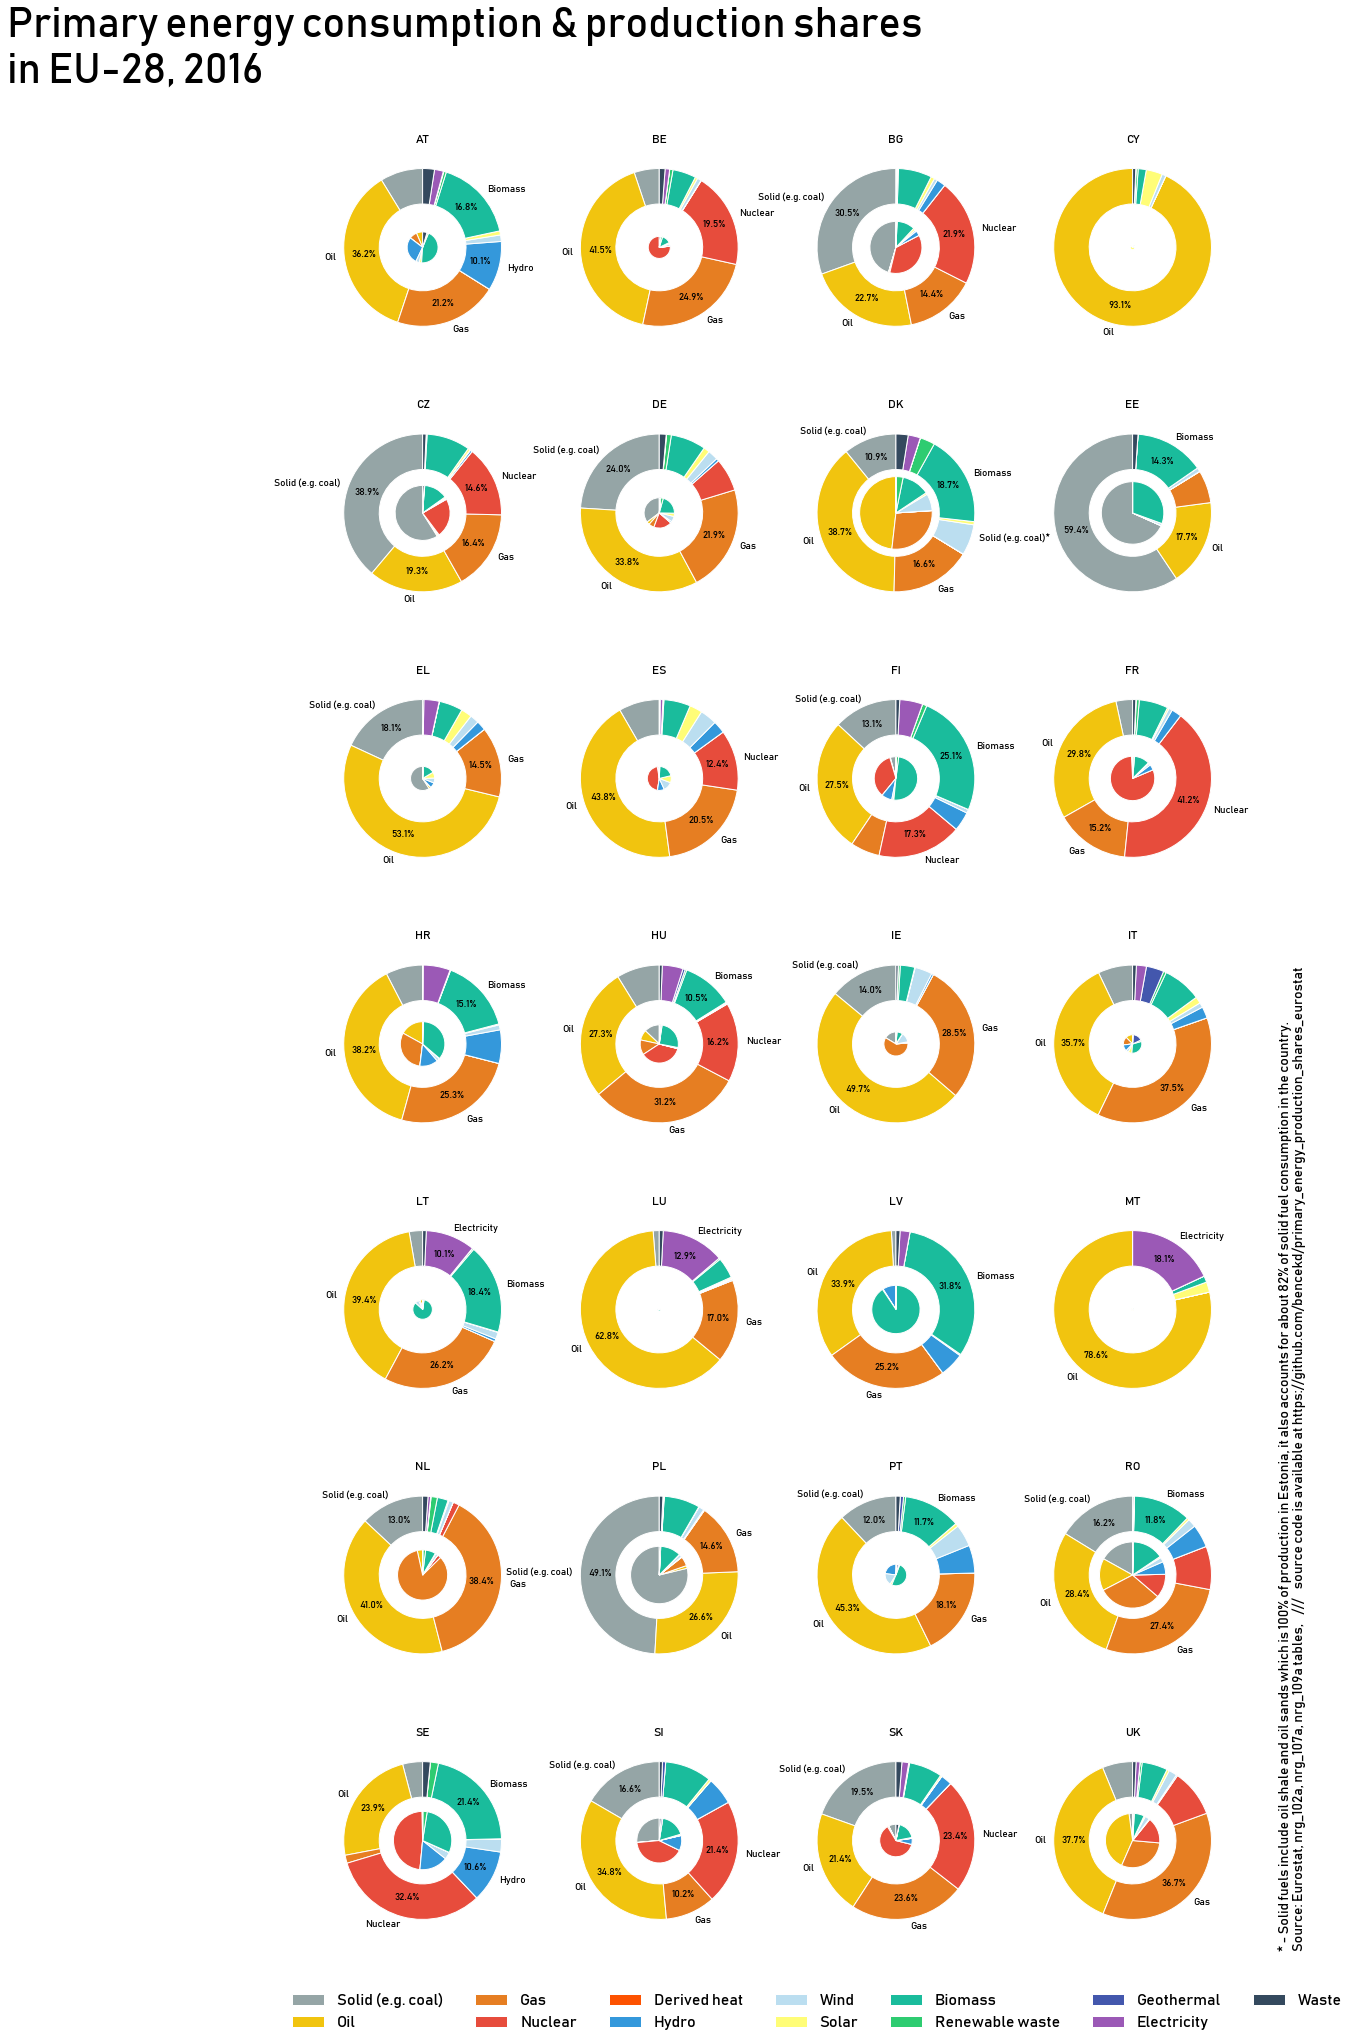

In [33]:
# create donut charts

import math

plt.rcParams["font.family"] = "Bahnschrift"

fig, ax = plt.subplots(7,4)
fig.subplots_adjust(bottom=0.08)
fig.subplots_adjust(top=0.92)
fig.subplots_adjust(left=0.27)
size = 0.45

# defines sorter, sorting energy sources

sorter = ["Solid (e.g. coal)","Oil","Gas","Nuclear","Derived heat",\
          "Hydro","Wind","Solar","Biomass","Renewable waste","Geothermal","Electricity","Waste"]

categories = sorter

pie_data['cn'] = pie_data['cn'].astype('category')
pie_data['cn'].cat.set_categories(sorter, inplace=True)

for i, ctr in enumerate(pie_data['geo'].unique()):
    pos_x = i % 4
    pos_y = math.floor(i / 4)
    
    outer_colors = ["#95A5A6","#F1C40F","#E67E22","#E74C3C","#FD5200",\
                    "#3498DB","#BBDEF0","#FFFD77","#1ABC9C","#2ECC71","#4357AD","#9B59B6","#34495E"]
    
    def pct_f(pct):
        if pct >= 10:
            return '%1.1f%%' % pct
        else:
            return ''
    
    # the total > 0 condition is used to be in line with Eurostat data usage (there could be data
    # exports in consumption which in turn is indicated with a negative value, e.g.: electricity
    # in Estonia)
    
    prod = pie_data[(pie_data['geo'] == ctr) & (pie_data['ind'] == 'prod') & (pie_data['total'] > 0)]\
    .groupby(['cn']).agg({"total":"sum"}).reset_index()
    for cat in categories:
        if cat not in prod['cn'].unique():
            prod = prod.append(pd.Series([cat,0], index=['cn', 'total']), ignore_index=True)
    prod = prod.sort_values(by=['cn'])

    prod['perc'] = prod['total'].apply(lambda x: x / prod['total'].sum())
    prod['labs'] = prod.apply(lambda x: x['cn'] if x['perc'] >= 0.1 else '', axis=1)
    
    cons = pie_data[(pie_data['geo'] == ctr) & (pie_data['ind'] == 'cons') & (pie_data['total'] > 0)]\
    .groupby(['cn']).agg({"total":"sum"}).reset_index()
    for cat in categories:
        if cat not in cons['cn'].unique():
            cons = cons.append([cat,0])
    cons = cons.sort_values(by=['cn'])
    
    cons['perc'] = cons['total'].apply(lambda x: x / cons['total'].sum())
    cons['labs'] = cons.apply(lambda x: x['cn'] if x['perc'] >= 0.1 else '', axis=1)
    
    # we're flagging Coal for EE as it's mostly oil shale and oil sands
    if ctr == 'EE':
        cons.loc[(cons['cn']=='Solid (e.g. coal)'),'labs'] = 'Solid (e.g. coal)*'
    
    p_c = prod['total'].sum() / cons['total'].sum()
    
    ax[pos_y, pos_x].pie(prod['total'], radius=p_c * (1-size), colors=outer_colors,
       wedgeprops=dict(width=p_c * (1-size), edgecolor='w'), pctdistance=0.75, startangle=90)

    ax[pos_y, pos_x].pie(cons['total'], labels=cons['labs'], radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), autopct=pct_f, pctdistance=0.75, startangle=90)

    ax[pos_y, pos_x].set(aspect="equal", title='{}'.format(ctr))
    
ax[6,1].legend(categories, loc='upper center', bbox_to_anchor=(1.3, -0.2),\
               ncol=math.ceil(len(categories)/2), frameon=False, fontsize=16)

fig.suptitle('Primary energy consumption & production shares \nin EU-28, 2016', fontsize=42, ha='left', x=0.05)
fig.text(0.94,0.08,'* - Solid fuels include oil shale and oil sands which is 100% of production in Estonia,' + \
         ' it also accounts for about 82% of solid fuel consumption in the country.',\
         fontsize=14,ha='left',rotation=90, rotation_mode='anchor')
fig.text(0.95,0.08,'Source: Eurostat, nrg_102a, nrg_107a, nrg_109a tables,' + \
         '    ///    source code is available at https://github.com/bencekd/primary_energy_production_shares_eurostat',fontsize=14,ha='left',\
        rotation=90, rotation_mode='anchor')
fig.set_size_inches(20, 30)
fig.savefig('primary_production_consumption_2016_EU28.png', dpi=300)
# fig